In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tools #helper and plotting functions

import xdem
import pandas as pd
import numpy as np
from pathlib import Path
from pyproj import Transformer
import matplotlib.pyplot as plt

### Coregistration tutorial

**Objective**  
Correct absolute vertical and horizontal error with respect to the reference terrain. This correction can then be applied back to the camera positions, prior to a final bundle adjustment and dense cloud / DEM / ortho generation.

**This notebook demonstrates how to:**
- Introduce an artifical x,y,z translation to a [small mountainous region](https://maps.app.goo.gl/vSXHshtdiUqb5xj58) in the Casa Grande reference DEM. The region is chosen because it highlights offsets well. Assume this is the output from a first bundle adjustment and has a systematic offset.
- Correct sub-pixel translation offsets using the [Nuth and Kääb](https://tc.copernicus.org/articles/5/271/2011/) coregistration method, implemented in [xDEM](https://xdem.readthedocs.io/en/latest/coregistration.html#nuthkaab)
- Apply the translation back to the camera positions.

### Prepare reference DEM

In [3]:
data_dir = Path('/mnt/workshop-storage/tutorial_data/coregistration/casa_grande/')

In [4]:
# reference_dem_path = 'reference_dem_zoom.tif'
reference_dem_clip_path = data_dir /'reference_dem_zoom_clip_aoi_10m.tif'

In [5]:
# %%capture
# !mkdir data
# !gdalwarp -te 431000 3627000 436000 3634000 \
#   -te_srs EPSG:26912 \
#   -r cubic -tr 10 10 \
#   -co TILED=YES -co COMPRESS=LZW -co BIGTIFF=IF_SAFER  \
#   {reference_dem_path} {reference_dem_clip_path}

### Load reference DEM 

In [6]:
reference_dem = xdem.DEM(reference_dem_clip_path)

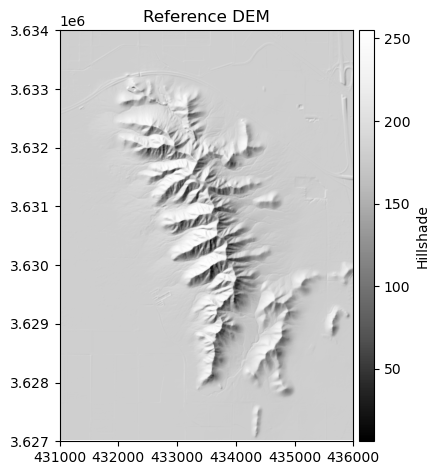

In [7]:
reference_dem_hillshade = reference_dem.hillshade()
reference_dem_hillshade.plot(cmap="Greys_r", cbar_title="Hillshade")
plt.title('Reference DEM');

### Create artificial translation

In [8]:
x_shift = 10
y_shift = 2
z_shift = 1

matrix = np.array(
    [
        [1, 0, 0, x_shift],
        [0, 1, 0, y_shift],
        [0, 0, 1, z_shift],
        [0, 0, 0, 1],
    ]
)

dem = xdem.DEM(xdem.coreg.apply_matrix(reference_dem, matrix))

In [9]:
diff_before = dem - reference_dem

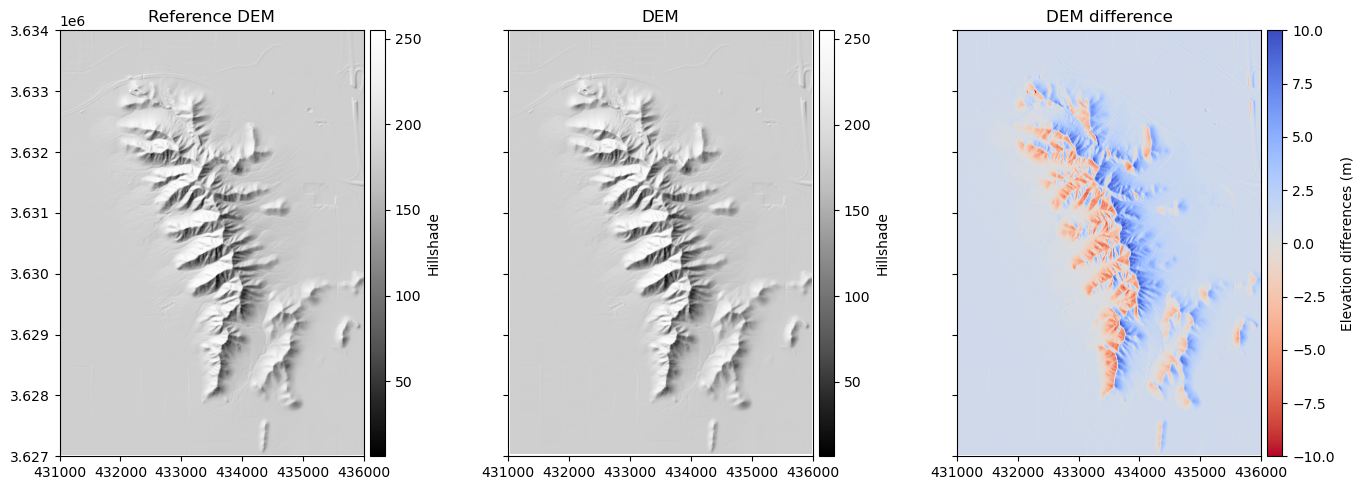

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(14,5))
reference_dem_hillshade.plot(ax=ax[0],cmap="Greys_r", cbar_title="Hillshade")
dem.hillshade().plot(ax=ax[1],cmap="Greys_r", cbar_title="Hillshade")
diff_before.plot(ax=ax[2],cmap="coolwarm_r", vmin=-10, vmax=10, cbar_title="Elevation differences (m)")

ax[0].set_title("Reference DEM")
ax[1].set_title("DEM")
ax[2].set_title("DEM difference")
ax[1].set_yticklabels([])
ax[2].set_yticklabels([])
plt.tight_layout()

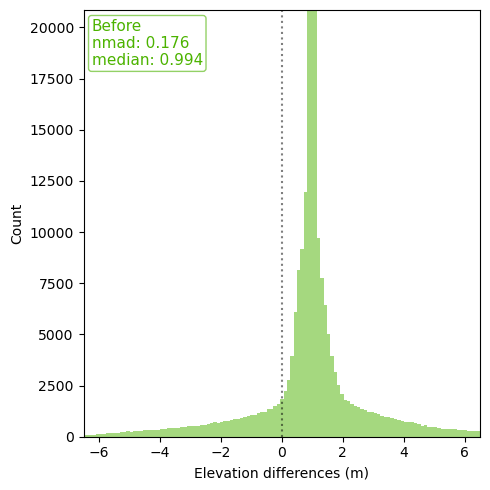

In [11]:
tools.plot_diff_histogram([diff_before.data],
                          ['Before'],
                          error_metrics = ['nmad', 'median']);

### Apply Nuth and Kääb translation correction

In [12]:
nuth_kaab = xdem.coreg.NuthKaab()
aligned_dem = nuth_kaab.fit_and_apply(reference_dem, dem)

In [13]:
diff_after = aligned_dem - reference_dem

In [14]:
dh_vmax = 10

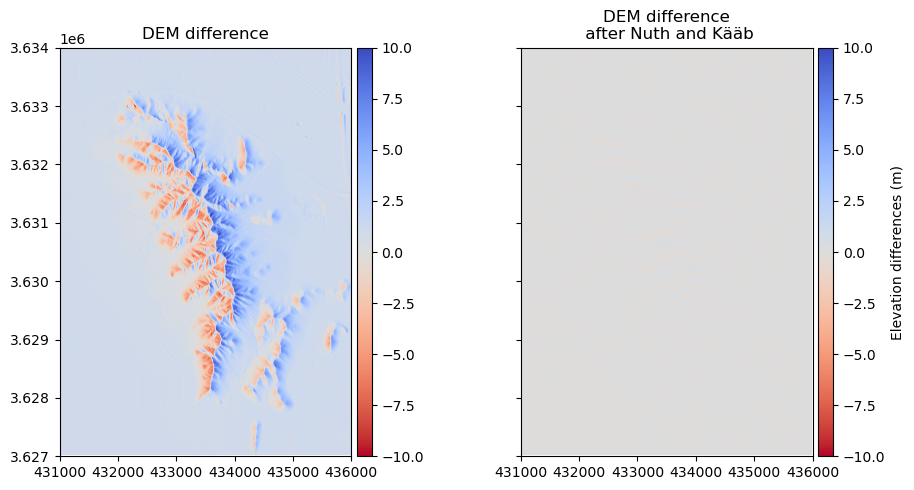

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
diff_before.plot(cmap="coolwarm_r", vmin=-dh_vmax, vmax=dh_vmax, ax=ax[0])
diff_after.plot(cmap="coolwarm_r", vmin=-dh_vmax, vmax=dh_vmax, ax=ax[1], cbar_title="Elevation differences (m)")
ax[0].set_title("DEM difference")
ax[1].set_title("DEM difference\n after Nuth and Kääb")
ax[1].set_yticklabels([])
plt.tight_layout()

In [16]:
shift_x = nuth_kaab.meta["outputs"]["affine"]["shift_x"]
shift_y = nuth_kaab.meta["outputs"]["affine"]["shift_y"]
shift_z = nuth_kaab.meta["outputs"]["affine"]["shift_z"]

print('artificial shift in x:',x_shift,'m')
print('artificial shift in y:',y_shift,'m')
print('artificial shift in z:',z_shift,'m')
print('mean dh:', np.round(diff_before.data.mean(),5),'m','\n')
print('corrected shift in x:',np.round(shift_x,5),'m')
print('corrected shift in y:',np.round(shift_y,5),'m')
print('corrected shift in z:',np.round(shift_z,5),'m')
print('mean residual dh:', np.round(diff_after.data.mean(),5),'m')

artificial shift in x: 10 m
artificial shift in y: 2 m
artificial shift in z: 1 m
mean dh: 0.98498 m 

corrected shift in x: -10.00388 m
corrected shift in y: -1.99053 m
corrected shift in z: -1.0003 m
mean residual dh: -0.00029 m


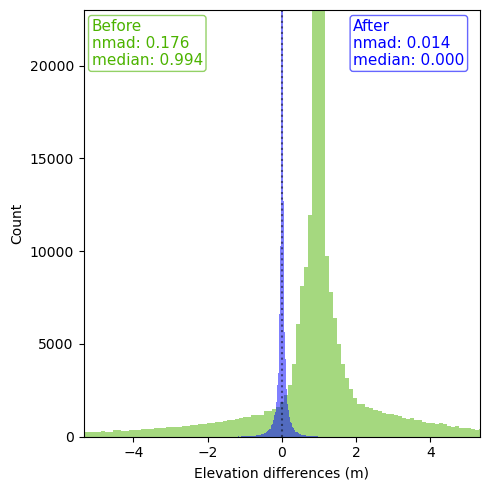

In [17]:
tools.plot_diff_histogram([diff_before.data, diff_after.data],
                          ['Before', 'After'],
                          error_metrics = ['nmad', 'median']);

### Load camera extrinsics before and after bundle adjustment

In [18]:
initial_extrinsics_path = data_dir / 'camera_model_extrinsics.csv'
bundle_adjusted_extrinsics_path = data_dir / 'bundle_adjusted_camera_model_extrinsics.csv'

In [19]:
initial_extrinsics_df = pd.read_csv(initial_extrinsics_path)
bundle_adjusted_extrinsics_df = pd.read_csv(bundle_adjusted_extrinsics_path)[initial_extrinsics_df.keys()]

In [20]:
initial_extrinsics_df.head()

,image_file_name,lon,lat,alt
0,ARBCSRD00010006.tif,-111.716543,32.915160,3810
1,ARBCSRD00010007.tif,-111.716891,32.894945,3810
2,ARBCSRD00010008.tif,-111.716569,32.872712,3810
3,ARBCSRD00010009.tif,-111.716386,32.852701,3810
4,ARBCSRD00010015.tif,-111.757795,32.917873,3810


In [21]:
bundle_adjusted_extrinsics_df.head()

,image_file_name,lon,lat,alt
0,ARBCSRD00010006.tif,-111.716176,32.916803,4360.998948
1,ARBCSRD00010007.tif,-111.716309,32.895240,4357.913488
2,ARBCSRD00010008.tif,-111.716802,32.873668,4355.761675
3,ARBCSRD00010009.tif,-111.717433,32.852088,4361.177138
4,ARBCSRD00010015.tif,-111.758647,32.920173,4359.234493


  X (longitude) shift: mean=-0.002378°, std=0.002229°
  Y (latitude) shift: mean=-0.000154°, std=0.002055°
  Z (altitude) shift: mean=553.705m, std=4.870m
Auto-calculated oval scale factor: 1.81 m/m


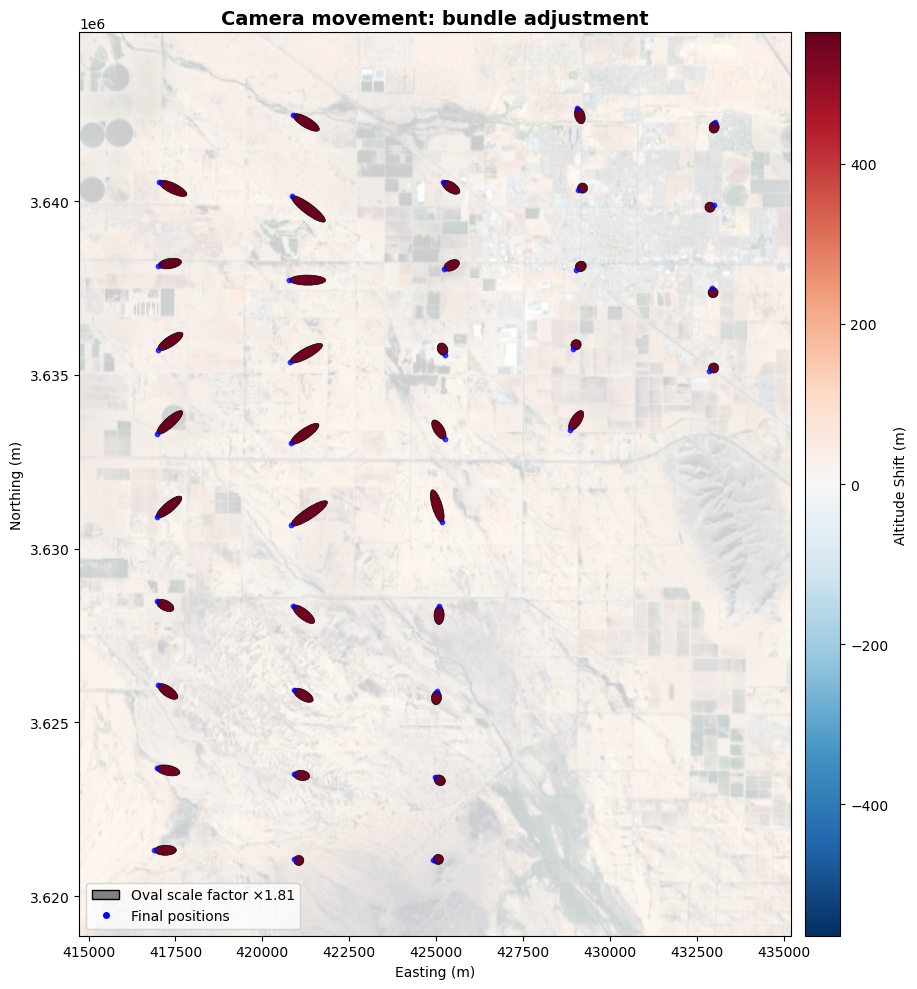


Dataset statistics:
  Initial positions: 37 points
  Final positions: 37 points
  Matched positions: 37 points

Position shift statistics (projected coordinates):
  X shift: mean=-222.69m, std=205.76m
  Y shift: mean=-15.31m, std=224.77m
  Altitude shift: mean=553.70m, std=4.87m
  Oval scale factor used: 1.81


In [22]:
tools.plot_extrinsics_comparison(initial_extrinsics_df, 
                                 bundle_adjusted_extrinsics_df,
                                 plot_ovals = True,
                                 oval_scale_factor = None,
                                 oval_alpha = 1,
                                 basemap_alpha = 0.2,
                                 basemap_xyz = "https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
                                 colormap = "managua",
                                 cbar_title = "Altitude Shift (m)",
                                 verbose = True,
                                 show_ticks = True,
                                 plot_title = "Camera movement: bundle adjustment",
                                )

### Apply shift back to camera positions

#### Bundle adjusted camera positions

In [23]:
bundle_adjusted_extrinsics_df.head()

,image_file_name,lon,lat,alt
0,ARBCSRD00010006.tif,-111.716176,32.916803,4360.998948
1,ARBCSRD00010007.tif,-111.716309,32.895240,4357.913488
2,ARBCSRD00010008.tif,-111.716802,32.873668,4355.761675
3,ARBCSRD00010009.tif,-111.717433,32.852088,4361.177138
4,ARBCSRD00010015.tif,-111.758647,32.920173,4359.234493


#### Convert to reference DEM CRS

In [24]:
epsg_code = tools.get_epsg_code(reference_dem_clip_path)
epsg_refdem = "EPSG:"+epsg_code
to_proj = Transformer.from_crs("EPSG:4326", epsg_refdem, always_xy=True)

df = bundle_adjusted_extrinsics_df.copy()

lon = df['lon'].to_numpy()
lat = df['lat'].to_numpy()
alt = df['alt'].to_numpy()

X, Y, Z = to_proj.transform(lon, lat, alt)

#### Apply transform to camera positions

In [25]:
X_t = X + shift_x
Y_t = Y + shift_y
Z_t = Z + shift_z

to_geo  = Transformer.from_crs(epsg_refdem, "EPSG:4326", always_xy=True)

lon_t, lat_t, h_t = to_geo.transform(X_t, Y_t, Z_t)

transformed_extrinsics_df = bundle_adjusted_extrinsics_df.copy()
transformed_extrinsics_df["lon"] = lon_t
transformed_extrinsics_df["lat"] = lat_t
transformed_extrinsics_df["alt"] = h_t

In [26]:
transformed_extrinsics_df.head()

,image_file_name,lon,lat,alt
0,ARBCSRD00010006.tif,-111.716283,32.916785,4359.998651
1,ARBCSRD00010007.tif,-111.716415,32.895222,4356.913190
2,ARBCSRD00010008.tif,-111.716909,32.873649,4354.761378
3,ARBCSRD00010009.tif,-111.717540,32.852069,4360.176841
4,ARBCSRD00010015.tif,-111.758754,32.920154,4358.234196


### Examine shifts

  X (longitude) shift: mean=-0.000107°, std=0.000000°
  Y (latitude) shift: mean=-0.000019°, std=0.000000°
  Z (altitude) shift: mean=-1.000m, std=0.000m
Auto-calculated oval scale factor: 106.20 m/m


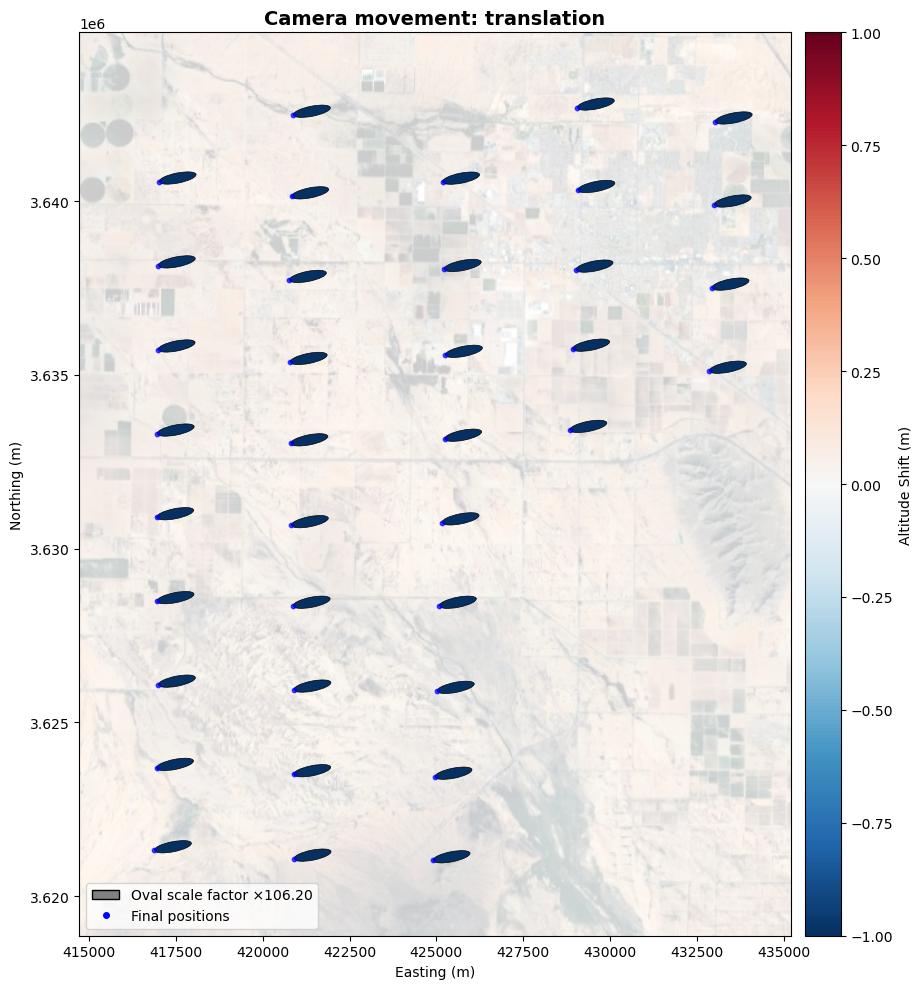


Dataset statistics:
  Initial positions: 37 points
  Final positions: 37 points
  Matched positions: 37 points

Position shift statistics (projected coordinates):
  X shift: mean=-10.00m, std=0.00m
  Y shift: mean=-1.99m, std=0.00m
  Altitude shift: mean=-1.00m, std=0.00m
  Oval scale factor used: 106.20


In [27]:
tools.plot_extrinsics_comparison(bundle_adjusted_extrinsics_df,
                                 transformed_extrinsics_df, 
                                 plot_ovals = True,
                                 oval_scale_factor = None,
                                 oval_alpha = 1,
                                 basemap_alpha = 0.2,
                                 basemap_xyz = "https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
                                 colormap = "managua",
                                 cbar_title = "Altitude Shift (m)",
                                 verbose = True,
                                 show_ticks = True,
                                 plot_title = "Camera movement: translation",
                                )

### Finally, re-run bundle adjustment with updated camera positions...